In [19]:
import numpy
from numpy.random import randn
from openfermion.transforms._jordan_wigner import *
from openfermion.utils._trotter_exp_to_qgates import *
from openfermion.utils import (commutator, count_qubits, expectation,
                               hermitian_conjugated, normal_ordered,
                               jordan_wigner_sparse, jw_hartree_fock_state,
                               s_squared_operator, sz_operator)

from openfermion.utils._unitary_cc import (uccsd_generator,
                                           uccsd_singlet_generator,
                                           uccsd_singlet_get_packed_amplitudes,
                                           uccsd_singlet_paramsize)

In [20]:
test_orbitals = 4

single_amplitudes = randn(*(test_orbitals,) * 2)
double_amplitudes = randn(*(test_orbitals,) * 4)
print('singles')
print(single_amplitudes)
print('doubles')
print(double_amplitudes)

singles
[[-0.19992084  1.3381955  -0.1234956   0.43386799]
 [-0.45991283 -2.46321797 -0.49435012  0.9583078 ]
 [-1.44274522  0.43163465 -0.17552953  0.4422718 ]
 [-0.55636355  0.25648739  0.11961159  0.72163247]]
doubles
[[[[-0.99340849 -0.68462449  1.91862263  0.17224418]
   [-0.3492247   0.62670574 -1.13493455  1.86862758]
   [-1.92300519  0.96427505  0.42857066 -0.28424277]
   [-0.94995434 -0.42379743  0.08141275  0.63185169]]

  [[ 0.53666043  0.34688211  0.52462246  0.32191408]
   [ 1.26981846  1.70967005 -0.21564462 -1.53190439]
   [ 1.4014428   0.67728565 -0.38196287 -1.29301142]
   [ 1.47104323  0.76537091  0.75015172 -1.48944859]]

  [[ 0.14754847  0.28953432 -0.31853594 -1.61902258]
   [-0.17146561 -0.94281612 -0.58385301  0.12149443]
   [ 1.17132307 -1.01998173  0.61791703  0.21629542]
   [-0.7751419  -0.44997536 -0.48457659 -0.97682984]]

  [[-2.05786368 -1.20599999  0.51324244  0.53701288]
   [-1.4678635   0.10822725 -0.20009113  0.37634511]
   [-1.18179259 -0.2295822   1.

In [21]:
generator = uccsd_generator(single_amplitudes, double_amplitudes)
qubit_op = jordan_wigner(generator)
qubit_op *= 1.0j

# print('openferion pre trotterized generator')
# print(generator)
# print('')
# print(qubit_op)


# for qubit_terms, coefficient in qubit_op.terms.items():
#     print('')
#     print(coefficient)
#     for tensor_term in qubit_terms:
#         print(tensor_term[1], tensor_term[0])


In [22]:
from forestopenfermion.pyquil_connector import qubitop_to_pyquilpauli
from openfermion.ops import QubitOperator


In [23]:
pauli_sum_representation = qubitop_to_pyquilpauli(qubit_op)
# print(pauli_sum_representation)

In [24]:
from pyquil.quil import Program
from forestopenfermion import exponentiate
from pyquil.gates import *

pyquil_program = exponentiate(qubit_op)
pyquil_program = Program(X(0), X(1), pyquil_program)
# print(pyquil_program)
# print(len(pyquil_program))

# The correct answer

In [25]:
from pyquil.api import WavefunctionSimulator
from pyquil import Program


print('')
wfn = WavefunctionSimulator().wavefunction(pyquil_program)
print(wfn)


(-0.8809062611+0j)|0011> + (-0.1858962777+0j)|0101> + (0.033386433+0j)|0110> + (0.0826460827+0j)|1001> + (-0.0305403779+0j)|1010> + (-0.4249341002+0j)|1100>


In [26]:
# ['(0.000000 +0.000000 i) |0000>',
#  '(0.000000 +0.000000 i) |1000>',
#  '(0.000000 -0.000000 i) |0100>',
#  '(-0.555451 +0.000000 i) |1100>',
#  '(0.000000 -0.000000 i) |0010>',
#  '(-0.365344 +0.000000 i) |1010>',
#  '(-0.619681 +0.000000 i) |0110>',
#  '(0.000000 -0.000000 i) |1110>',
#  '(0.000000 +0.000000 i) |0001>',
#  '(0.055498 +0.000000 i) |1001>',
#  '(0.159086 +0.000000 i) |0101>',
#  '(0.000000 +0.000000 i) |1101>',
#  '(-0.381582 +0.000000 i) |0011>',
#  '(0.000000 -0.000000 i) |1011>',
#  '(0.000000 +0.000000 i) |0111>',
#  '(0.000000 +0.000000 i) |1111>']

# Now begin importing trial circuit to Qforte

In [27]:
import qforte

In [28]:
#get from openferion
qforte_generator = qforte.build_from_openfermion(qubit_op)
#qforte.smart_print(qforte_generator)

# Now try to exponentiate the full operator 

In [29]:
expn_generator = qforte.trotterization.trotterize(qforte_generator)
#qforte.smart_print(expn)
#expn.str()

In [30]:
# Set HF state
qc2 = qforte.QuantumComputer(4)
qc2.apply_gate(qforte.make_gate('X',0,0))
qc2.apply_gate(qforte.make_gate('X',1,1))
#qc2.str()

In [31]:
qc2.apply_circuit(expn_generator)
qc2.str()

['(0.000000 +0.000000 i) |0000>',
 '(0.000000 -0.000000 i) |1000>',
 '(0.000000 +0.000000 i) |0100>',
 '(-0.880906 +0.000000 i) |1100>',
 '(0.000000 +0.000000 i) |0010>',
 '(-0.185896 +0.000000 i) |1010>',
 '(0.033386 +0.000000 i) |0110>',
 '(0.000000 +0.000000 i) |1110>',
 '(0.000000 -0.000000 i) |0001>',
 '(0.082646 +0.000000 i) |1001>',
 '(-0.030540 +0.000000 i) |0101>',
 '(0.000000 -0.000000 i) |1101>',
 '(-0.424934 +0.000000 i) |0011>',
 '(0.000000 -0.000000 i) |1011>',
 '(0.000000 -0.000000 i) |0111>',
 '(0.000000 +0.000000 i) |1111>']

# Now set up for variational optemization via VQE

In [14]:
# import to get hamiltonian from psi 
import unittest
import qforte
from openfermion.hamiltonians import MolecularData
from openfermion.transforms import get_fermion_operator, jordan_wigner
from openfermionpsi4 import run_psi4
import numpy

# Get data for H2

In [15]:
# Set molecule parameters.
basis = 'sto-3g'
multiplicity = 1
bond_length_interval = 0.2
n_points = 8

# Set calculation parameters.
run_scf = 1
run_mp2 = 0
run_cisd = 0
run_ccsd = 1
run_fci = 1
delete_input = True
delete_output = True

# Generate molecule at different bond lengths.
hf_energies = []
ccsd_energies = []
fci_energies = []
qforte_hamiltonians = [None]*n_points
bond_lengths = []
for point in range(1, n_points + 1):
    bond_length = bond_length_interval * float(point)
    bond_lengths += [bond_length]
    geometry = [('H', (0., 0., 0.)), ('H', (0., 0., bond_length))]
    molecule = MolecularData(
        geometry, basis, multiplicity,
        description=str(round(bond_length, 2)))
    
    # Run Psi4.
    molecule = run_psi4(molecule,
                        run_scf=run_scf,
                        run_mp2=run_mp2,
                        run_cisd=run_cisd,
                        run_ccsd=run_ccsd,
                        run_fci=run_fci)
    
    #make energy array
    hf_energies += [molecule.hf_energy]
    ccsd_energies += [molecule.ccsd_energy]
    fci_energies += [molecule.fci_energy]
    
    #populate data and integrals
    molecule.load()

    # Get the Hamiltonian in an active space.
    active_space_start = 0
    active_space_stop = 2

    molecular_hamiltonian = molecule.get_molecular_hamiltonian(
        occupied_indices=range(active_space_start),
        active_indices=range(active_space_start, active_space_stop))

    # Map operator to fermions and qubits.
    fermion_hamiltonian = get_fermion_operator(molecular_hamiltonian)
    qubit_hamiltonian = jordan_wigner(fermion_hamiltonian)
    #qubit_hamiltonian.compress()
    # print('The Jordan-Wigner Molecular Hamiltonian in canonical basis:\n{}'.format(qubit_hamiltonian))

    # print('\nBuild Qforte Hamiltonian and generator to calculate the expectation value')
    qforte_hamiltonians[point-1] = qforte.build_from_openfermion(qubit_hamiltonian)
    # print('\nThe Molecular Hamiltonian in canonical basis:')
    # qforte.smart_print(qforte_hamiltonian)
    
#     print('Hartree-Fock energy of {} Hartree.'.format(molecule.hf_energy))
#     print('Hartree-Fock energy of {} Hartree.'.format(molecule.ccsd_energy))
#     print('Hartree-Fock energy of {} Hartree.'.format(molecule.fci_energy))

# Set up VQE object

In [16]:
uccsd_energies = [0.0]*n_points
for i in range(n_points):
    myVQE = qforte.VQE(4, 2, expn_generator, qforte_hamiltonians[i], 10000)
    
    Exper2 = qforte.Experiment(4, 2, expn_generator, qforte_hamiltonians[i], 10000)
    params2 = [0.0] * 44 
    
    
    optemized = myVQE.do_vqe()
    uccsd_energies[i] = optemized.fun

    print('')
    print('vals')

    print(fci_energies[i])
    print(Exper2.experimental_avg(params2))
    print(hf_energies[i])
    print(optemized.fun)
    print(ccsd_energies[i])
    

44

vals
0.15748213365503538
2.1578410046817087
0.1641750109193325
2.1167713291681562
0.15748213366406702
0

vals
-0.9141497050119485
0.5152960735034151
-0.9043613945444622
0.5231472307646455
-0.91414970488679
0

vals
-1.1162860069722234
-0.11681522830936918
-1.1011282423609585
-0.12227681652754684
-1.1162860069744933
0

vals
-1.134147666642846
-0.4404936183848433
-1.1108503974239035
-0.4457001493632437
-1.134147666715479
0

vals
-1.1011503301329562
-0.6233647348581463
-1.0661086491853147
-0.6172487144418919
-1.1011503317008027
0

vals
-1.0567407461794298
-0.7198115255890274
-1.005106706387666
-0.716616330467959
-1.0567407459635745
0

vals
-1.0154682491653264
-0.7815954731100124
-0.9414806545013791
-0.7859755504491944
-1.0154682452064738
0

vals
-0.9834727289323327
-0.8148786443995532
-0.8817324497321232
-0.8121776208366976
-0.9834727297224256


In [17]:
print(uccsd_energies)
print(optemized.fun)

[2.1167713291681562, 0.5231472307646455, -0.12227681652754684, -0.4457001493632437, -0.6172487144418919, -0.716616330467959, -0.7859755504491944, -0.8121776208366976]
-0.8121776208366976


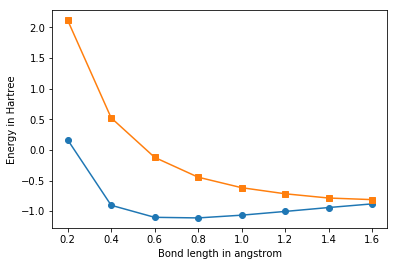

In [18]:
# Plot.
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(0)
# plt.plot(bond_lengths, fci_energies, 'x-')
plt.plot(bond_lengths, hf_energies, 'o-')
# plt.plot(bond_lengths, ccsd_energies, 'd-')
plt.plot(bond_lengths, uccsd_energies, 's-')
plt.ylabel('Energy in Hartree')
plt.xlabel('Bond length in angstrom')
plt.show()